# Imports and load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import scipy.misc
import pandas as pd
import datetime

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn import svm

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from __future__ import print_function
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from keras.optimizers import Adadelta, Adam

Using TensorFlow backend.


## Kaggle API

In [2]:
!pip install kaggle

In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


## **load data**

In [4]:
!kaggle competitions download -c comp551w18-modified-mnist -p "./"
!ls
train_x = np.loadtxt("./train_x.csv", delimiter=",")
train_y = np.loadtxt("./train_y.csv", delimiter=",")
test_x = np.loadtxt("./test_x.csv", delimiter=",")

train_y.csv: Skipping, found more recently modified local copy (use --force to force download)
train_x.csv: Skipping, found more recently modified local copy (use --force to force download)
test_x.csv: Skipping, found more recently modified local copy (use --force to force download)
datalab  test_x.csv  train_x.csv  train_y.csv


In [0]:
#storing a backup copy if we accidentally overwrite data, saves from reloading
backup_train_x = np.copy(train_x)
backup_train_y = np.copy(train_y)
backup_test_x = np.copy(test_x)
 
#restore backup
def restore():
  train_x = np.copy(backup_train_x)
  train_y = np.copy(backup_train_y)
  test_x = np.copy(backup_test_x)
  return train_x, train_y, test_x

In [0]:
train_x = train_x.reshape(-1, 64, 64) # reshape
train_y = train_y.reshape(-1, 1)


# Sample printed images

[4.] [7.] [1.] [0.] [8.]


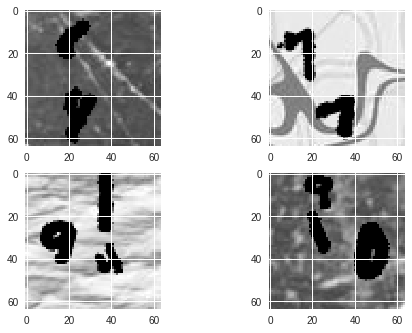

In [7]:
print(train_y[0],train_y[1],train_y[2],train_y[3],train_y[4])

plt.subplot(221)
plt.imshow(train_x[0],cmap='gray_r')
plt.subplot(222)
plt.imshow(train_x[1],cmap='gray_r')
plt.subplot(223)
plt.imshow(train_x[2],cmap='gray_r')
plt.subplot(224)
plt.imshow(train_x[3],cmap='gray_r')
plt.show()

# Preprocessing


## Black N White function

In [0]:
def img_blackNwhite(img,thresh=254,maxValue=255):
  ''' function for turning original image into black and white image
      using threshold
  '''
  # turn image to binary black and white
  th, dst = cv2.threshold(img, thresh, maxValue, cv2.THRESH_BINARY);
  
  # convert numpy array to unsigned 8 bit to work with FindCountours()
  dst = dst.astype(np.uint8)
  
  return dst

## Remove images with touching digits

In [0]:
def remove_touching_images(X,y_label,thresh=254,maxValue=255):
  
  images = []
  labels = []
  
  counter = -1
  for img in X:
    counter+=1
    # turn image black and white
    dst = img_blackNwhite(img,thresh,maxValue)
  
    # Find Contours
    image, contours, hier = cv2.findContours(dst, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    
    # within each image look at the bounding boxes
    count = 0 # count is used to just append the image once 
    for cnt in contours:
      count+=1
      x,y,w,h = cv2.boundingRect(cnt)
      
      # if the dimensions are good append
      if((w <= 36 and w > 0) and (h > 0 and h <= 36)):
        if(count==1):
          images.append(img)
          labels.append(y_label[counter])
      
      # if the dim are not good
      else:
        break
  # turn them into numpy arrays
  images = np.asarray(images)
  labels = np.asarray(labels)
  
  return images,labels

In [10]:
print("before removal {0}, {1}".format(train_x.shape,train_y.shape))

train_x_wo_touching,train_y_wo_touching = remove_touching_images(train_x,train_y)

print("after removal")
print(train_x_wo_touching.shape)
print(train_y_wo_touching.shape)

before removal (50000, 64, 64), (50000, 1)
after removal
(49828, 64, 64)
(49828, 1)


## Bounding images

In [0]:
def get_bounding_image(img,thresh=254,maxValue=255):
  
  ''' 
      function that returns the subimages from img using bounding box approach
      with a threshold
      
      - input: is a 64 x 64 image, the treshold and maxValue for seperating background
      - return: list of subimages (as numpy matricies) from img 
  '''
  
  # turn image to binary black and white
  dst = img_blackNwhite(img)
  
  # Find Contours
  image, contours, hier = cv2.findContours(dst, cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
  
  # Get images in the countours
  images = []
  for cnt in contours:
    
    x,y,w,h = cv2.boundingRect(cnt)
    images.append(image[y:y+h,x:x+w])  
    
  return images

## Resize


In [0]:
def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [0]:
def rescale_images(images,rescale_size=(20,20), pad = 4):
 
  ''' given a set of raw images (or preprocessed images)
     returns another set of rescaled images based on rescale_size
     
     images: list of images
     rescale_size: the size we wish to resize the images to, default is 28x28
                   the size of MNIST
     return: list of resized images
 '''
  scaled_images=[]
 
  for image in images:
    # get subimages
    sub_images =  get_bounding_image(image)
    for sub_img in sub_images:
      # resize
      dst = resizeAndPad(sub_img, rescale_size, padColor= 0)
      #padding
      dst = cv2.copyMakeBorder(dst, pad, pad, pad, pad, borderType=0)
      #save
      scaled_images.append(dst)
 
  return np.asarray(scaled_images)

In [0]:
def rescale(image,rescale_size=(20,20), pad = 4):
  
  ''' function for rescaling just one image
  
      input: a bounding box type image
      return: rescaled image close to MNIST
  '''
  dst = resizeAndPad(image, rescale_size, padColor= 0)
  #padding
  dst = cv2.copyMakeBorder(dst, pad, pad, pad, pad, borderType=0)
  return dst 
    

# Methods for picking the largest subimage

## Count pixels

In [0]:
def count_pixels(image):
  ''' returns the count of all the non zero pixel in an image
  '''
  counter = 0
  for row in image:
    for element in row:
      if (element != 0): counter +=1
  return counter

def count_pixels_gray(image):
  ''' returns the sum of all the non zero pixel in an image
  '''
  norm = image/255
  counter = 0
  for row in norm:
    for element in row:
      if (element != 0): counter += element
  return counter



## find largest based on area

In [0]:
# a way of choosing between the subimages for a given image
def find_largest_count(images):
  
  '''
     given a set of subimages, returns the subimage that was the largest in area
     
     images: set of subimages, like the ones return by get_bounding_image
     return: numpy array of largest integer 
  '''
  
  counts=[]
  for img in images:
    counts.append(count_pixels_gray(img))

  index = counts.index(max(counts))  
  
  return images[index]

# a way of choosing between the subimages for a given image
def find_largest_axes(images):
  
  '''
     given a set of subimages, returns the subimage that was the largest in area
     
     images: set of subimages, like the ones return by get_bounding_image
     return: numpy array of largest integer 
  '''
  
  counts=[]
  for img in images:

    counts.append(max(img.shape))

  index = counts.index(max(counts))  
  
  return images[index]

## find largest based on ratio

In [0]:
# another way of choosing between the subimages for a given image

def find_largest_count_ratio(images):
  '''
      returns largest subimage based on the ratio of pixel counts between the actual subimage and the MNIST scaled version
  '''
  
  count_ratios=[]
  for img in images:

    pre_scaled_count = count_pixels_gray(img)
    
    post_scaled = rescale(img)
    post_scaled_count = count_pixels_gray(post_scaled)
    
    ratio = pre_scaled_count/post_scaled_count
  
    count_ratios.append( ratio )
  
  # find the max image based on ratio
  max_val = max(count_ratios)
  index = count_ratios.index(max_val) 
  
  return images[index]

# Changing the dataset to just contain one subimage

## Replacing dataset with chosen images

In [0]:
def new_data(data,method):
  
  ''' 
    function to go from dataset --> upto 3 preprocessed subimages 
    return the X given a method of choosing between the subimages
    (for example using find_largest_count or looking at ratios)
    
    we go from raw data to data that just has one subimage included
    
    input: raw image data
    return: chosen subimages data
  '''
  
  new_data = []
  
  for image in data:
   # get subimgs
    sub_images =  get_bounding_image(image.reshape(64,64))
    #find the largest one
    largest = method(sub_images)    
    #resize it
    dst = rescale(largest)
    #dst = resizeAndPad(largest, (28,28), padColor= 0) # previous way of rescaling img
    #save it
    new_data.append(dst)

  return np.asarray(new_data)


In [35]:
#runing code to get modified dataset 

print(train_x_wo_touching.shape)
new_x_train_data = new_data(train_x_wo_touching,find_largest_count_ratio)

# Uncomment code below to get a dataset using find_largest_axes instead:
#new_x_train_data = new_data(train_x_wo_touching,find_largest_axes) 

print(new_x_train_data.shape)

(49828, 64, 64)
(49828, 28, 28)


In [0]:
#data augmentation
def transform_image(img,ang_range, shear_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    
    
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
  # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    
    shear_M = cv2.getAffineTransform(pts1,pts2)

    
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    
    return img
#dst = transform_image(new_x_train_data[0], 360, 2)


def dataAugment(images, labels, factor = 5):
  new_img = []
  new_labels = []
  for img in range(0,len(images)):
    for i in range(0,factor):
      dst = transform_image(images[img], 360, 2)
      new_img.append(dst)
      new_labels.append(labels[img])
      
  return np.asarray(new_img), np.asarray(new_labels)

# temp_img, temp_labels = dataAugment(new_x_train_data, train_y_wo_touching)
# print(new_x_train_data.shape, train_y_wo_touching.shape)
# print(temp_img.shape, temp_labels.shape)

# Evaluating models

In [0]:
def preprocessing_CNN(x):
 
  ''' function for pre processing our images for CNN input
  
      x: already rescaled subimages 
      
      return: x ready for input into CNN
             
  '''

  img_rows, img_cols = 28, 28
  
  x_copy = np.copy(x)
  x_copy = x_copy.reshape(x.shape[0], img_rows, img_cols, 1)
  x_copy = x_copy.astype('float32')
  x_copy /= 255

  return x_copy

In [0]:
def flatten(data):
  
  flattened_data = []
  for entry in data:
    flattened_data.append(entry.flatten())
    
  return np.asarray(flattened_data)

## neural network

In [46]:
"""
Simplistic implementation of the two-layer neural network.
Training method is stochastic (online) gradient descent with momentum.
As an example it computes XOR for given input.
Some details:
- tanh activation for hidden layer
- sigmoid activation for output layer
- cross-entropy loss
Less than 100 lines of active code.
"""

import numpy as np
import time

n_hidden = 28
n_in = 784
n_out = 10
n_samples = 300

learning_rate = 0.01
momentum = 0.9

np.random.seed(0)


def Sigmoid_forward(X):
     return 1.0 / (1.0 + np.exp(-X))



# class Tanh:
#     def forward(self, X):
#         return np.tanh(X)

#     def backward(self, X, top_diff):
#         output = self.forward(X)
#         return (1.0 - np.square(output)) * top_diff


def Softmax_loss(X, y):
    num_examples = X.shape[0]
    probs = Softmax_predict(X)
    data_loss = 0
    for i in range(num_examples):
      corect_logprobs = -np.log(probs[i]*y[i])
      data_loss += corect_logprobs
    return 1./num_examples * data_loss
    #loss = -np.mean ( true * np.log(Y) + (1 - true) * np.log(1 - Y) )
    #return loss

def Softmax_predict(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    

def Softmax_diff(X, y):
    num_examples = X.shape[0]
    probs = Softmax_predict(X)
    probs[range(num_examples), y] -= 1
    return probs
      

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def tanh_prime(x):
    return  1 - np.tanh(x)**2

def softmax_loss_naive(W, X, y, reg= 0):
  """
  Softmax loss function, naive implementation (with loops)
  Inputs:
  - W: C x D array of weights 
  - X: D x N array of data. Data are D-dimensional columns
  - y: 1-dimensional array of length N with labels 0...K-1, for K classes for us the one hot encoded
  - reg: (float) regularization strength
  Returns:
  a tuple of:
  - loss as single float
  - gradient with respect to weights W, an array of same size as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)

  #############################################################################
  # Compute the softmax loss and its gradient using explicit loops.           #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################

  # Get shapes
  num_classes = W.shape[0]
  num_train = X.shape[1]

  for i in range(num_train):
    # Compute vector of scores
    f_i = W.dot(X[:, i]) # in R^{num_classes}

    # Normalization trick to avoid numerical instability, per http://cs231n.github.io/linear-classify/#softmax
    log_c = np.max(f_i)
    f_i -= log_c

    # Compute loss (and add to it, divided later)
    # L_i = - f(x_i)_{y_i} + log \sum_j e^{f(x_i)_j}
    sum_i = 0.0
    for f_i_j in f_i:
      sum_i += np.exp(f_i_j)
    loss += -f_i[y[i]] + np.log(sum_i)

    # Compute gradient
    # dw_j = 1/num_train * \sum_i[x_i * (p(y_i = j)-Ind{y_i = j} )]
    # Here we are computing the contribution to the inner sum for a given i.
    for j in range(num_classes):
      p = np.exp(f_i[j])/sum_i
      dW[j, :] += (p-(j == y[i])) * X[:, i]

  # Compute average
  loss /= num_train
  dW /= num_train

  # Regularization
  loss += 0.5 * reg * np.sum(W * W)
  dW += reg*W

  return loss, dW



def train(x, true, V, W, bv, bw):

    # forward
    print (x.shape)
    print (np.dot(x, V).shape)

    A = np.dot(x, V) + bv
    Z = np.tanh(A)

    B = np.dot(Z, W) + bw
    Y = Softmax_predict(B)
    print (A.shape)
    print (Y.shape)

    # backward
    Ew, dW = softmax_loss_naive(W,x, true)
    print (Ew.shape)
    Ev = tanh_prime(A) * np.dot(W, Ew)

    #dW = Softmax_dW(x,true)
    dV = np.outer(x, Ev)

    loss = -np.mean ( true * np.log(Y) + (1 - true) * np.log(1 - Y) )

    # Note that we use error for each layer as a gradient
    # for biases

    return  loss, (dV, dW, Ev, Ew)

def predict(x, V, W, bv, bw):
    A = np.dot(x, V) + bv
    B = np.dot(np.tanh(A), W) + bw
    return (sigmoid(B) > 0.5).astype(int)

# Setup initial parameters
# initalizing on random wieghts

V = np.random.normal(scale=0.1, size=(n_in, n_hidden))
W = np.random.normal(scale=0.1, size=(n_hidden, n_out))

bv = np.zeros(n_hidden)
bw = np.zeros(n_out)

params = [V,W,bv,bw]

# Generate some data

X = flatten(new_x_train_data)

T = keras.utils.to_categorical(train_y_wo_touching, 10)


# Train
for epoch in range(100):
    err = []
    upd = [0]*len(params)

    t0 = time.clock()
    loss, grad = train(X, T, *params)
    params -= upd
    upd = learning_rate * grad + upd
    
#     for i in range(X.shape[0]):
# #         loss, grad = train(X[i], T[i], *params)

#         for j in range(len(params)):
#             #params[j] -= upd[j]

#         for j in range(len(params)):
#             upd[j] = learning_rate * grad[j] + momentum * upd[j]

    err.append( loss )
        
        
        

(49828, 784)
(49828, 28)
(49828, 28)
(49828, 10)


ValueError: ignored

In [83]:
flatten(new_x_train_data).shape

(49828, 784)

## Transfer Learning attempt

In [24]:
'''Transfer learning attempt


1 - Train a simple convnet on the MNIST dataset 
2 - Freeze convolutional layers and fine-tune dense layers
   for the classification of digits from our dataset.
Get to 99.8% test accuracy after 5 epochs
for the first five digits classifier
and 99.2% for the last five digits after transfer + fine-tuning.
'''



now = datetime.datetime.now

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = [3,2]
# convolution kernel size
kernel_size = [4,3,2]

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)


def train_model(model, train, test, num_classes):
  
    x_train = train[0].reshape((train[0].shape[0],) + input_shape)
    x_test = test[0].reshape((test[0].shape[0],) + input_shape)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(train[1], num_classes)
    y_test = keras.utils.to_categorical(test[1], num_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    t = now()
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])


# the data, split between train and test sets
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()


x_train = new_x_train_data
y_train = train_y_wo_touching
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


# # create two datasets one with digits below 5 and one with 5 and above
# x_train_lt5 = x_train[y_train < 5]
# y_train_lt5 = y_train[y_train < 5]
# x_test_lt5 = x_test[y_test < 5]
# y_test_lt5 = y_test[y_test < 5]

# x_train_gte5 = x_train[y_train >= 5]
# y_train_gte5 = y_train[y_train >= 5] - 5
# x_test_gte5 = x_test[y_test >= 5]
# y_test_gte5 = y_test[y_test >= 5] - 5

# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size[0],
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size[1],
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size[0]),
    Dropout(0.25),
#     Conv2D(filters, kernel_size[2]),
#     Activation('relu'),
#     MaxPooling2D(pool_size=pool_size[1]),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.3),
    Dense(num_classes),
    Activation('softmax')
]

# create complete model
model = Sequential(feature_layers + classification_layers)

# train model for mnist
train_model(model,
            (mnist_x_train, mnist_y_train),
            (mnist_x_test, mnist_y_test), num_classes)

# freeze feature layers and rebuild model
for l in feature_layers[2:]:
    l.trainable = False

# transfer: train dense layers for new classification task [5..9]
train_model(model,
            (x_train, y_train),
            (x_test, y_test), num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
56576/60000 [===========================>..] - ETA: 0s - loss: 0.2884 - acc: 0.9102

KeyboardInterrupt: ignored

## Simple CNN 

In [25]:
'''Trains a simple convnet on the dataset.
'''
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.model_selection import train_test_split

batch_size = 64
num_classes = 10
epochs = 16

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
x_train = new_x_train_data
y_train = train_y_wo_touching
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train[0].reshape( img_rows, img_cols).shape)


# example way of showing 
# plt.imshow(x_train[0].reshape(img_rows, img_cols),cmap='gray')
# plt.show()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (39862, 28, 28, 1)
39862 train samples
9966 test samples
(28, 28)
Train on 39862 samples, validate on 9966 samples
Epoch 1/16
21760/39862 [===============>..............] - ETA: 4s - loss: 0.9045 - acc: 0.7183

KeyboardInterrupt: ignored

## Cross validation

In [0]:
def create_model(dropout = 0.2, optimizer=Adam() ,activation_fct = 'relu'):
  
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                   activation=activation_fct,
                   input_shape=(28,28,1)))
  model.add(Conv2D(64, (3, 3), activation=activation_fct))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(dropout))
  model.add(Flatten())
  model.add(Dense(128, activation=activation_fct))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax')) #last layer activation is always softmax

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

In [27]:
seed = 7

num_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
num_classes = 10

x_train = new_x_train_data
y_train = train_y_wo_touching

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
                                                    test_size=0.33, random_state=42)


# format X data correctly
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# one hot encoding of y
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape, y_train.shape)
print(y_test.shape,x_test.shape)

epochs = [5,10,15]
batch_size = [50,64,100]
dropout =[0.2,0.3,0.5]
activation = ['relu','sigmoid']
optimizer = [Adadelta(),Adam()]

# one example of the way we did hyperparameter tuning using (here for epochs) 
for e in epochs:
  # create model
  model = KerasClassifier(build_fn=create_model, epochs=e, 
                          batch_size=64, verbose=0)
  
  # impliment cross validation
  cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
  # get cross val scores
  scores = cross_val_score(model, x_train, y_train, cv=cv)
  # print scores
  print("feature value is: {0}".format(d))
  print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

(33384, 28, 28, 1) (33384, 10)
(16444, 10) (16444, 28, 28, 1)


NameError: ignored

## SVM with preprocessed data

In [0]:
def flatten_data(data):
  ''' list of data to flatten 
      example of change: (40 000 entries,28,28) ----> (40 000 entries,28x28=784)
  '''
  new_data = []
  for entry in data:
    new_data.append(entry.flatten())
    
  return np.asarray(new_data)

In [0]:
#flatten the new data

print(new_x_train_data.shape)
flat_new_x_train_data = flatten_data(new_x_train_data)
print(flat_new_x_train_data.shape)

(49828, 28, 28)
(49828, 784)


In [0]:
# split the data

x_train, x_test, y_train, y_test = train_test_split(flat_new_x_train_data, train_y_wo_touching, test_size=0.2, random_state=42)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(50000,)
(39862, 784) (39862,)
(9966, 784) (9966,)


In [0]:
svm = svm.SVC(kernel='rbf') # svm with different kernel
svm = LinearSVC() 
svm.fit(x_train, y_train)
preds = svm.predict(x_test)
acc = accuracy_score(y_test, preds)

print('got accuracy: {}'.format(acc))

In [90]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'ensemble.csv'})
uploaded.SetContentFile('ensemble.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Uploaded file with ID 1yn3i4EMoXMLVxFPNFBUrIbV5h46JoG85


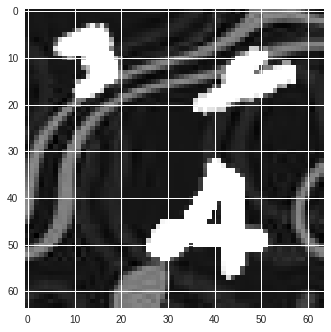

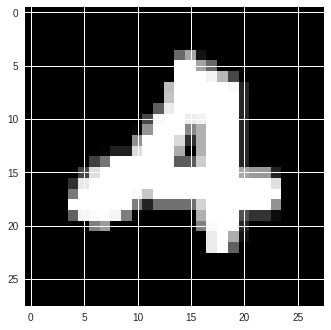

1

In [92]:
# # preprocess the dataset to fit into CNN's
# preprocessed_x_train = preprocessing_CNN(subimg_x_train)
# print(preprocessed_x_train.shape)

# # turn the y into categorical
# preprocessed_y_train = keras.utils.to_categorical(backup_train_y, num_classes)


#display preprocessed image [0]
i = 10
plt.imshow(backup_train_x[i].reshape(64,64),cmap='gray')
plt.show()

plt.imshow(new_x_train_data[i].reshape(28,28),cmap='gray')
plt.show()
predictions[i].argmax()
#display the expected output
#print(preprocessed_y_train[0])


# preds = model.predict(preprocessed_x_train)


In [0]:
score = model.evaluate(preprocessed_x_train,preprocessed_y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.581616075744629
Test accuracy: 0.68166


In [84]:

from google.colab import files
files.download(‘ensemble.csv’)


SyntaxError: ignored

## Baseline SVM ( takes a long time to train ~ 20 mins)

In [0]:
def flatten_data(data):
  print(data.shape[0])
  new_data = np.zeros((data.shape[0],4096))
  counter = 0
  for img in data:
    new_data[counter] = img.flatten()
    counter+=1
  return new_data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(flatten_data(train_x), train_y, test_size=0.2, random_state=42)

print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

50000
(40000, 4096) (40000, 1)
(10000, 4096) (10000, 1)


In [0]:
# train SVM

models = [LinearSVC()]
names = ['SVM']

for name, model in zip(names, models):
	model.fit(x_train, y_train.ravel())
	preds = model.predict(x_test)
	acc = accuracy_score(y_test, preds)
	print('Model {} got accuracy: {}'.format(name, acc))

ModelSVMgotaccuracy0.4436082681115794


# Submitting our predictions

In [0]:
#pre-process for predicting
def kagglePredict(model_name, df):
  predictions = model.predict(cnn_x_test).argmax(axis=1)
  df[model_name] = predictions
  return df


#kaggle = pd.DataFrame()
#kaggle.reset_index()
#kaggle["Id"] = kaggle.index

processed_x_test = new_data(np.copy(backup_test_x), find_largest_count_ratio)
cnn_x_test = preprocessing_CNN(processed_x_test)


In [76]:
#predicting
kaggle = kagglePredict("Max Pixel Vanilla, CNN Batch = " + str(batch_size)+", epochs = " + str(epochs), kaggle)

kaggle

,"Max Axes Vanilla, CNN Batch = 64, epochs = 16","Max Axes Vanilla, CNN Batch = 128, epochs = 16","Max Pixel Vanilla, CNN Batch = 128, epochs = 16","Max Pixel Vanilla, CNN Batch = 64, epochs = 16"
0,7,7,7,7
1,2,2,2,2
2,0,0,0,0
3,7,7,7,7
4,6,6,6,6
5,1,1,1,1
6,5,5,5,5
7,3,3,3,3
8,8,8,8,8
9,1,1,1,1


In [0]:
sub = kaggle.mode(axis = 1)[0].astype(int)
sub.to_csv("ensemble.csv")

Downloading our predictions

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



# Analyzing MNIST

In [0]:
def load_flattened_mnist():
  '''returns flattened x_train, x_test and y_train, y_test of mnist dataset
 '''
  (mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
  num_pixels = mnist_x_train.shape[1] * mnist_x_train.shape[2]
  mnist_x_train = mnist_x_train.reshape(mnist_x_train.shape[0], num_pixels).astype('float32')
  mnist_x_test = mnist_x_test.reshape(mnist_x_test.shape[0], num_pixels).astype('float32')
 
  return mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test
 
def pixel_norm(x=mnist_x_train, y=mnist_y_train):
  '''function that returns the avg non zero pixel counts for each digit(label) in the image dataset
    set to mnist images by default
 
   input: flattened image dataset as x, labels as y
   returns: array of average pixel counts
 
 '''
 
  data = np.c_[x, y]
  pixels = [0] * 10 # empty list of size 10 where we will store sum of all the digit pixel counts
  counter = [0] * 10 # empty list of size 10 to store each time a digit is hit
 
  for entry in data:
 
    pixels[int(entry[-1])] += count_pixels(entry[:-1].reshape(28,28))
    counter[int(entry[-1])] += 1
 
  avg_pixel_mnist = [x/y for x, y in zip(pixels, counter)]
 
  return avg_pixel_mnist
 
mnist_x_train, mnist_x_test, mnist_y_train, mnist_y_test = load_flattened_mnist()
mnist_norm = pixel_norm(mnist_x_train, mnist_y_train)